# Проект номер 3

Представьте, что вы работаете аналитиком в компании, которая занимается арендой велосипедов. Коллега из офиса в Лондоне прислал вам данные за два года: с 4 января 2015 по 3 января 2017. Вам предстоит изучить динамику числа аренд, наличие связи с погодными условиями и выходными, а также объяснить несколько аномалий на графике.

## Описание данных

timestamp – дата и время (точность до часа)  
cnt – количество аренд велосипедов за этот час  
t1 – температура, в С  
t2 – температура "ощущается как", в С  
hum – влажность (%)  
wind_speed – скорость ветра, км/ч  
weather_code – погодные условия:  
1 – ясно (SKC)  
2 – преимущественно ясно / встречаются отдельные облака (SCT)  
3 – облачно / значительные облака (BKN)  
4 – пасмурно (OVC)  
7 – небольшой дождь Rain/ light Rain shower/ Light rain 
10 – дождь с грозой  
26 – снегопад 
94 – ледяной туман (да, такое бывает!)  
isholiday – является ли день праздником (1 – праздник, 0 – нет)  
isweekend –  является ли день выходным (1 – выходной, 0 – нет)  
season – метеорологический сезон (0 – весна, 1 – лето, 2 – осень, 3 – зима)  

## Задания

Загрузите данные, проверьте число наблюдений и столбцов, наличие пропусков. Убедитесь, что типы данных были прочитаны правильно. При необходимости – приведите переменные к нужным типам.  

1) Постройте график по числу поездок по дате и времени.  

2) Преобразуйте данные и посчитайте число поездок по дням. Визуализируйте результат.  

3) Используйте агрегированные данные по дням и посчитайте скользящее среднее с окном 3.В качестве ответа укажите полученное число аренд за 2015-07-09, округлив значение до целого.  

4) Посчитайте разницу между наблюдаемыми и значениями, подсчитанными с помощью скользящего среднего. Далее – найдите стандартное отклонение.  

5) Определите границы 99% доверительного интервала, добавьте данную информацию в датафрейм.  

6) Изучите аномально высокие значения и укажите день, когда число аренд было наибольшим. Найдите причину данной аномалии.  

7) Изучите аномально низкие значения, найдите день с наименьшим числом аренд. Найдите причину данной аномалии.  

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import scipy

In [2]:
london = pd.read_csv('../Lesson3/london.csv')

## Задание 1
Загрузите данные, проверьте число наблюдений и столбцов, наличие пропусков. Убедитесь, что типы данных были прочитаны правильно. При необходимости – приведите переменные к нужным типам.

Проверяем, есть ли пропущенные значения

In [3]:
london.isna().any()

timestamp       False
cnt             False
t1              False
t2              False
hum             False
wind_speed      False
weather_code    False
is_holiday      False
is_weekend      False
season          False
dtype: bool

In [4]:
london.head()

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
0,2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
1,2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0
2,2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
3,2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0
4,2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0


Проверим типы данных. Видим, что время прочитано как строка

In [5]:
london.dtypes

timestamp        object
cnt               int64
t1              float64
t2              float64
hum             float64
wind_speed      float64
weather_code    float64
is_holiday      float64
is_weekend      float64
season          float64
dtype: object

Конвертируем строку во время

In [6]:
london['timestamp']=pd.to_datetime(london.timestamp)

## Задание 2
Для начала попробуем посмотреть на число поездок по датам и времени. Постройте график, где:

- по оси x – дата (timestamp)  
- по оси y – число поездок (cnt)

Посмотрим распределение поездок по дате и времени

In [7]:
london_dates_cnt = london.sort_values('timestamp', ascending=True) \
    .groupby(['timestamp'], as_index=False).agg({'cnt':'sum'})

In [8]:
london_dates_cnt

,timestamp,cnt
0,2015-01-04 00:00:00,182
1,2015-01-04 01:00:00,138
2,2015-01-04 02:00:00,134
3,2015-01-04 03:00:00,72
4,2015-01-04 04:00:00,47
...,...,...
17409,2017-01-03 19:00:00,1042
17410,2017-01-03 20:00:00,541
17411,2017-01-03 21:00:00,337
17412,2017-01-03 22:00:00,224


Сложно что-то понять из графика

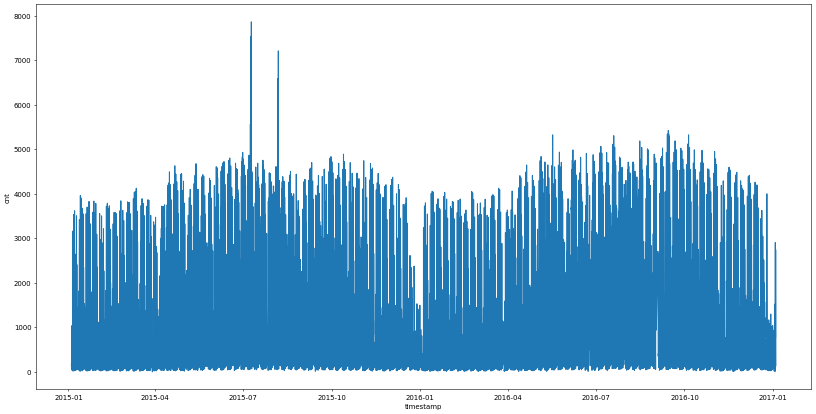

In [9]:
plt.figure(figsize=(20,10), dpi=50)
sns.lineplot(data=london_dates_cnt, x='timestamp', y='cnt', hue=None,)
plt.show()

## Задание 3
Агрегируйте число поездок по дням и визуализируйте результат

Попробуем посмотреть число поездок только по дате (без времени)

In [10]:
dates_cnt = london_dates_cnt

Чтобы применить метод resample необходимо поместить в индекс значение дат

In [11]:
dates_cnt.set_index('timestamp', drop=False, inplace=True)

Из графика видно, что имеются пики, когда поездок очень много, обычно это происходит летом. Видим сразу, что имеются как минимум три аномалии. 
Максимальное число аренд в день было более 70000

<AxesSubplot:xlabel='timestamp'>

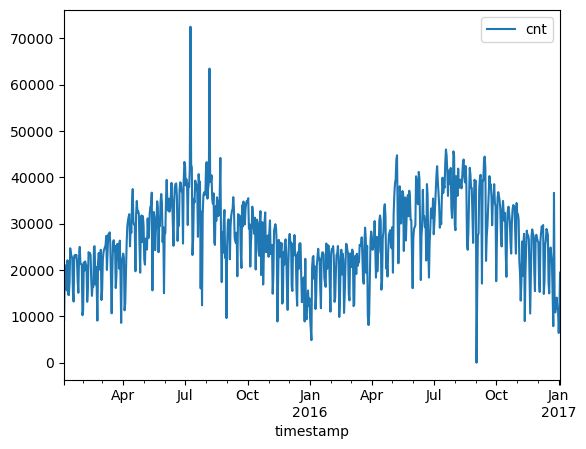

In [12]:
dates_cnt.sort_index(axis=0, ascending=True).resample(rule='D').agg({'cnt':'sum'}).plot()
#только оставляем дату без времени

## Задание 4

Давайте проверим, что же могло произойти в те дни - и насколько эти изменения для нас неожиданны.
Построим доверительный интервал вокруг данных - всё, что выпадает за его пределы, будет считаться аномалией, и на отдельные из них мы потом и посмотрим.

Однако не всё так просто. Мы сейчас работаем с временным рядом - последовательностью значений, меняющейся во времени. Мы не можем просто так посчитать доверительный интервал для всего: так мы можем упустить важные характеристики данных! Например, сезонные колебания.  

Чтобы учесть этот момент, мы построим доверительный интервал, используя скользящее среднее. Для этого разделим дальнейшие действия на несколько этапов:  

- сначала посчитаем скользящее среднее, чтобы сгладить ряд  
- далее – разницу между наблюдаемыми и сглаженными значениями  
- определим верхние и нижние границы 99% доверительного интервала  
- найдем причины аномалий!  

In [13]:
dates_cnt = dates_cnt.resample(rule='D').agg({'cnt':'sum'}).reset_index(drop=False)

In [14]:
dates_cnt

,timestamp,cnt
0,2015-01-04,9234
1,2015-01-05,20372
2,2015-01-06,20613
3,2015-01-07,21064
4,2015-01-08,15601
...,...,...
726,2016-12-30,11566
727,2016-12-31,11424
728,2017-01-01,6421
729,2017-01-02,11823


In [15]:
dates_cnt['rolling_mean'] = dates_cnt['cnt'].rolling(window=3).mean()
#считаем скользящее среднее

In [16]:
dates_cnt

,timestamp,cnt,rolling_mean
0,2015-01-04,9234,NaN
1,2015-01-05,20372,NaN
2,2015-01-06,20613,16739.666667
3,2015-01-07,21064,20683.000000
4,2015-01-08,15601,19092.666667
...,...,...,...
726,2016-12-30,11566,12682.000000
727,2016-12-31,11424,12347.333333
728,2017-01-01,6421,9803.666667
729,2017-01-02,11823,9889.333333


<AxesSubplot:>

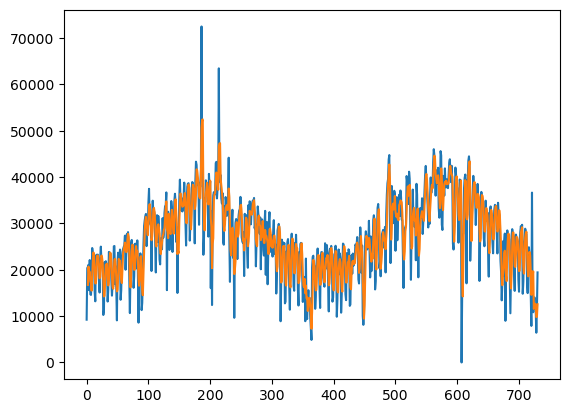

In [17]:
dates_cnt.cnt.plot()
dates_cnt.rolling_mean.plot()

Посмотрим полученное число аренд за 2015-07-09

In [18]:
dates_cnt[dates_cnt['timestamp'] == '2015-07-09']

,timestamp,cnt,rolling_mean
186,2015-07-09,72504,50705.0


Теперь посчитаем разницу между наблюдаемыми и сглаженными значениями

In [19]:
dates_cnt_dif=dates_cnt['cnt'] - dates_cnt['rolling_mean']

In [20]:
dates_cnt_dif=pd.DataFrame(data=dates_cnt_dif)

In [21]:
dates_cnt_dif

,0
0,NaN
1,NaN
2,3873.333333
3,381.000000
4,-3491.666667
...,...
726,-1116.000000
727,-923.333333
728,-3382.666667
729,1933.666667


Определим стандартное отклонение значений разниц

In [22]:
std=np.std(dates_cnt_dif)

In [23]:
std

0    4558.586641
dtype: float64

Определим верхние и нижние границы 99% доверительного интервала 

In [24]:
dates_cnt['upper_bound']=dates_cnt['rolling_mean']+(2.576*4558.586641)
dates_cnt['lower_bound']=dates_cnt['rolling_mean']-(2.576*4558.586641)

In [25]:
dates_cnt

,timestamp,cnt,rolling_mean,upper_bound,lower_bound
0,2015-01-04,9234,NaN,NaN,NaN
1,2015-01-05,20372,NaN,NaN,NaN
2,2015-01-06,20613,16739.666667,28482.585854,4996.747479
3,2015-01-07,21064,20683.000000,32425.919187,8940.080813
4,2015-01-08,15601,19092.666667,30835.585854,7349.747479
...,...,...,...,...,...
726,2016-12-30,11566,12682.000000,24424.919187,939.080813
727,2016-12-31,11424,12347.333333,24090.252521,604.414146
728,2017-01-01,6421,9803.666667,21546.585854,-1939.252521
729,2017-01-02,11823,9889.333333,21632.252521,-1853.585854


Посмотрим на аномалии, которые больше верхней границы ДИ. Видим, что число аренг 2015-07-09 72504 (наибольшее)
Погуглив увидим, что в этот день в лондоне были забастовки в метро

In [26]:
dates_cnt[dates_cnt.cnt>dates_cnt.upper_bound]

,timestamp,cnt,rolling_mean,upper_bound,lower_bound
186,2015-07-09,72504,50705.000000,62447.919187,38962.080813
214,2015-08-06,63468,46627.333333,58370.252521,34884.414146
609,2016-09-04,27512,14259.000000,26001.919187,2516.080813
721,2016-12-25,36653,19650.666667,31393.585854,7907.747479


Посмотрим на аномалии, которые меньше нижней границы ДИ. наименьшее число ареннд было 2016-09-02. Явная ошибка при сборе данных

In [27]:
dates_cnt[dates_cnt.cnt<dates_cnt.lower_bound]

,timestamp,cnt,rolling_mean,upper_bound,lower_bound
130,2015-05-14,15609,28709.333333,40452.252521,16966.414146
189,2015-07-12,23240,36036.666667,47779.585854,24293.747479
201,2015-07-24,16034,31013.666667,42756.585854,19270.747479
232,2015-08-24,17400,29529.333333,41272.252521,17786.414146
314,2015-11-14,8898,21037.333333,32780.252521,9294.414146
607,2016-09-02,0,26086.333333,37829.252521,14343.414146
615,2016-09-10,17080,31262.000000,43004.919187,19519.080813
621,2016-09-16,21967,36193.333333,47936.252521,24450.414146
678,2016-11-12,8990,20878.000000,32620.919187,9135.080813
